In [ ]:
# Importing required libraries
import numpy as np 
import cv2
import matplotlib.pyplot as plt  
from scipy.optimize import nnls
import random
from numpy import linalg as la
from scipy.fftpack import *
import warnings
import math
import pywt as tr
import mlpy
import mlpy.wavelet as wa
warnings.filterwarnings("ignore")

In [ ]:
# Function to plot image
def img_plot(im):
  plt.figure(figsize=(3,3))
  plt.imshow(im,cmap='gray')
  plt.show()

# Function to calculate the PSNR value
def PSNR(I1,I2): 
    
    MSE = (I1 - I2)
    MSE = MSE**2
    MSE = np.mean(MSE) 
    p = 20*math.log10(255.0) - 10*math.log10(MSE)
    return p   

# Function to gaussian blur
def Blur(image,sigma,size):
  
  k = cv2.getGaussianKernel(size[0], sigma)
  kernel = np.dot(k,k.T)

  x , y =  kernel.shape
  a = x//2
  b = y//2

  image_n = cv2.copyMakeBorder( image, a,a,b,b, cv2.BORDER_REPLICATE)

  new_I = np.zeros((image.shape))
  for i in range(a,image_n.shape[0]-a,1):
    for j in range(b,image_n.shape[1]-b,1):
      new_I[i-a][j-b] = np.sum(image_n[i-a:i+a+1,j-b:j+b+1]*kernel)
 
  return new_I 


  


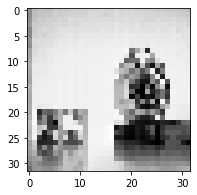

Image Shape :  (32, 32)


In [ ]:
# Load the 32x32 image
path = '/content/drive/MyDrive/Projects/DIP_Assignments/Test_Images/5.1.12.tiff'
im = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
im = cv2.resize(im,(32,32)) 
img_plot(im)
print('Image Shape : ',im.shape)

In [ ]:
# Analysis Prior with DCT

def Analysis_Prior_DCT(H,y):

  alpha = np.linalg.eig(np.dot(H.T,H)) 
  al1 = alpha[0]
  al2 = alpha[1]
  al1 = np.array(al1).flatten()
  al2 = np.array(al2).flatten()

  alpha = np.max(np.concatenate((al1,al2)))+0.1

  c = 1.1

  lam = 0.1
  iter = 1000

  x = np.zeros((H.shape[0],1))
  z = np.zeros((H.shape[0],1))

  for i in range(iter):

    b  = x + (1/alpha)*np.dot(H.T,y-np.dot(H,x)) 

    t1 = c*z + dct((b-idct(z)))

    t2 = (2*alpha/lam)*((np.absolute(dct(x)))+c)
    
    z  = np.divide(t1, t2)

    x = b - idct(z) 

  x = np.reshape(x,(int(H.shape[0]**0.5),int(H.shape[0]**0.5)))
  return x

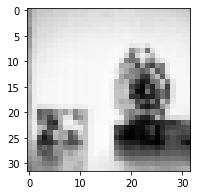

In [ ]:
1.
# Add noise to image with sigma 0.5
imn = Blur(im,0.5,(3,3))
img_plot(imn)

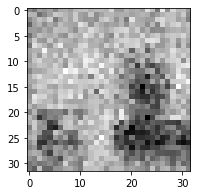

PSNR Value with noise(sigma = 0.5):  18.092181997245447


In [ ]:
H = np.random.normal(size=(1024,1024))
imn = np.reshape(imn,(1024,1))
y = np.dot(H,imn)

imnew = Analysis_Prior_DCT(H,y)
img_plot(imnew)

print('PSNR Value with noise(sigma = 0.5): ',PSNR(im,imnew))

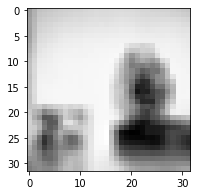

In [ ]:
2.
# Add noise to image with sigma 2
imn = Blur(im,2,(3,3))
img_plot(imn)

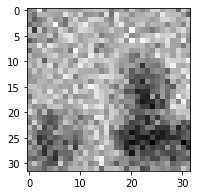

PSNR Value with noise(sigma = 2):  15.755349627012762


In [ ]:
H = np.random.normal(size=(1024,1024))
imn = np.reshape(imn,(1024,1))
y = np.dot(H,imn)

imnew = Analysis_Prior_DCT(H,y)
img_plot(imnew)

print('PSNR Value with noise(sigma = 2): ',PSNR(im,imnew))

In [ ]:
# Synthesis Prior with DCT
def soft(x,T):
  out = np.zeros(x.shape)
  for i in range(x.shape[0]):
    for j in range(x.shape[1]):
      if x[i,j]<=-T:
        out[i,j] = x[i,j]+T
      elif x[i,j]>T:
        out[i,j] = x[i,j]-T
      else:
        out[i,j] = 0  

  return out


def Synthesis_Prior_DCT(y):
  
  alpha = 1.1  
  x = np.zeros(y.shape)
  iter = 1000
  reg = 0.1

  for i in range(iter):
    mm = x + (1.0/alpha)*idct(y-dct(x))
    so = reg/(2.0*alpha)
    x = soft(mm,so)

  x = dct(x)
  x = x/np.max(x)
  x = x*255
  return x 

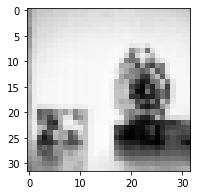

In [ ]:
1.
# Add noise to image with sigma 0.5
imn = Blur(im,0.5,(3,3))
img_plot(imn)

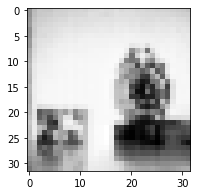

PSNR Value with noise(sigma = 0.5):  23.36307689766462


In [ ]:
imnew = Synthesis_Prior_DCT(imn)
img_plot(imnew) 

print('PSNR Value with noise(sigma = 0.5): ',PSNR(im,imnew))

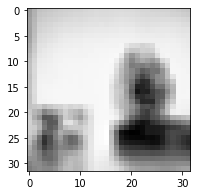

In [ ]:
2.
# Add noise to image with sigma 2
imn = Blur(im,2,(3,3))
img_plot(imn)

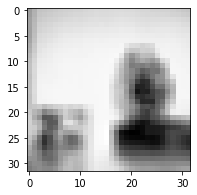

PSNR Value with noise(sigma = 2):  19.525414204811838


In [ ]:
imnew = Synthesis_Prior_DCT(imn)
img_plot(imnew) 

print('PSNR Value with noise(sigma = 2): ',PSNR(im,imnew))

In [ ]:
# Analysis Prior with FFT

def Analysis_Prior_FFT(H,y):

  alpha = np.linalg.eig(np.dot(H.T,H)) 
  al1 = alpha[0]
  al2 = alpha[1]
  al1 = np.array(al1).flatten()
  al2 = np.array(al2).flatten()

  alpha = np.max(np.concatenate((al1,al2)))+0.1

  c = 1.1

  lam = 400
  iter = 2000

  x = np.zeros((H.shape[0],1))
  z = np.zeros((H.shape[0],1))

  for i in range(iter):

    b  = x + (1/alpha)*np.dot(H.T,y-np.dot(H,x)) 

    F1 = np.fft.ifft(z)

    F1 = np.abs(F1).astype(np.uint64)
    
    t0 = b-F1
    F2 = np.fft.fft(t0)
    F2 = np.abs(F2).astype(np.uint64)
    
    t1 = c*z + F2

    F3 = np.fft.fft(x)
    F3 = np.abs(F3).astype(np.uint64)

    t2 = (2*alpha/lam)*((np.absolute(F3))+c)
    
    z  = np.divide(t1, t2)

    F_Inv = np.fft.ifft(z)
    F_Inv = np.abs(F_Inv).astype(np.uint64)

    x = b - F_Inv 


  x = np.reshape(x,(int(H.shape[0]**0.5),int(H.shape[0]**0.5)))
  return x

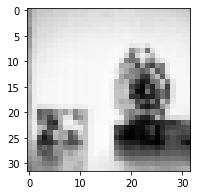

In [ ]:
1.
# Add noise to image with sigma 0.5
imn = Blur(im,0.5,(3,3))
img_plot(imn)

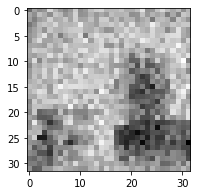

PSNR Value with noise(sigma = 0.5):  18.067897921988546


In [ ]:
H = np.random.normal(size=(1024,1024))
imn = np.reshape(imn,(1024,1))
y = np.dot(H,imn)

imnew = Analysis_Prior_FFT(H,y)
img_plot(imnew)

print('PSNR Value with noise(sigma = 0.5): ',PSNR(im,imnew))

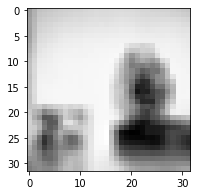

In [ ]:
2.
# Add noise to image with sigma 2
imn = Blur(im,2,(3,3))
img_plot(imn)

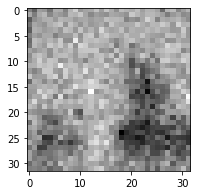

PSNR Value with noise(sigma = 2):  16.63387388737285


In [ ]:
H = np.random.normal(size=(1024,1024))
imn = np.reshape(imn,(1024,1))
y = np.dot(H,imn)

imnew = Analysis_Prior_FFT(H,y)
img_plot(imnew)

print('PSNR Value with noise(sigma = 2): ',PSNR(im,imnew))

In [ ]:
# Synthesis Prior with FFT
def soft(x,T):
  out = np.zeros(x.shape)
  for i in range(x.shape[0]):
    for j in range(x.shape[1]):
      if x[i,j]<=-T:
        out[i,j] = x[i,j]+T
      elif x[i,j]>T:
        out[i,j] = x[i,j]-T
      else:
        out[i,j] = 0  

  return out


def Synthesis_Prior_FFT(y):
  
  alpha = 1.1  
  x = np.zeros(y.shape)
  iter = 1000
  reg = 0.1

  for i in range(iter):
    F1 = np.fft.fft2(x)
    F1 = np.abs(F1).astype(np.uint64)
    
    F2 = y-F1
    F2 = np.fft.ifft2(F2)
    F2 = np.abs(F2).astype(np.uint64)

    mm = x + (1.0/alpha)*F2
    so = reg/(2.0*alpha)
    x = soft(mm,so)

  F3 = np.fft.fft2(x)
  F3 = np.abs(F3).astype(np.uint64)
  x = F3
  x = x/np.max(x)
  x = x*255
  return x 

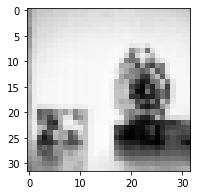

In [ ]:
1.
# Add noise to image with sigma 0.5
imn = Blur(im,0.5,(3,3))
img_plot(imn)

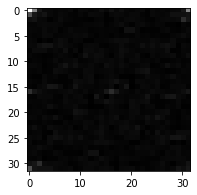

PSNR Value with noise(sigma = 0.5):  3.6239098457291092


In [ ]:
imnew = Synthesis_Prior_FFT(imn)
img_plot(imnew)

print('PSNR Value with noise(sigma = 0.5): ',PSNR(im,imnew))

In [ ]:
# Analysis Prior with DWT

def Analysis_Prior_DWT(H,y):

  alpha = np.linalg.eig(np.dot(H.T,H)) 
  al1 = alpha[0]
  al2 = alpha[1]
  al1 = np.array(al1).flatten()
  al2 = np.array(al2).flatten()

  alpha = np.max(np.concatenate((al1,al2)))+0.1

  c = 1.1

  lam = 0.1
  iter = 1

  x = np.zeros((H.shape[0],1))
  z = np.zeros((H.shape[0],1))

  for i in range(iter):

    b  = x + (1/alpha)*np.dot(H.T,y-np.dot(H,x)) 
    p1  = wa.idwt(X=z, wf=bytes('b','utf-8'), k=6)
    
    p2 = b - p1
    p2 = wa.dwt(x=p2, wf=bytes('b','utf-8'), k=6) 

    t1 = c*z + p2

    p3 = wa.dwt(x=x, wf=bytes('b','utf-8'), k=6) 

    t2 = (2*alpha/lam)*((np.absolute(p3))+c)

    z  = np.divide(t1, t2)

    p1  = wa.idwt(X=z, wf=bytes('b','utf-8'), k=6)
    x = b - p1 
    

  x = np.reshape(x,(int(H.shape[0]**0.5),int(H.shape[0]**0.5)))
  return x

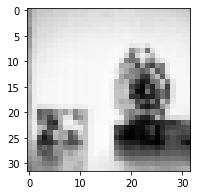

In [ ]:
1.
# Add noise to image with sigma 0.5
imn = Blur(im,0.5,(3,3))
img_plot(imn)

In [ ]:
H = np.random.normal(size=(1024,1024))
imn = np.reshape(imn,(1024,1))
y = np.dot(H,imn)

imnew = Analysis_Prior_DWT(H,y)
img_plot(imnew)

print('PSNR Value with noise(sigma = 0.5): ',PSNR(im,imnew))

In [ ]:
# Analysis Prior with DST

def Analysis_Prior_DST(H,y):

  alpha = np.linalg.eig(np.dot(H.T,H)) 
  al1 = alpha[0]
  al2 = alpha[1]
  al1 = np.array(al1).flatten()
  al2 = np.array(al2).flatten()

  alpha = np.max(np.concatenate((al1,al2)))+0.1

  c = 1.1

  lam = 0.001
  iter = 1000

  x = np.zeros((H.shape[0],1))
  z = np.zeros((H.shape[0],1))

  for i in range(iter):

    b  = x + (1/alpha)*np.dot(H.T,y-np.dot(H,x)) 

    t1 = c*z + dst((b-idst(z)))

    t2 = (2*alpha/lam)*((np.absolute(dst(x)))+c)
    
    z  = np.divide(t1, t2)

    x = b - idst(z) 

  x = np.reshape(x,(int(H.shape[0]**0.5),int(H.shape[0]**0.5)))
  return x

In [ ]:
1.
# Add noise to image with sigma 0.5
imn = Blur(im,0.5,(3,3))
img_plot(imn)

In [ ]:
H = np.random.normal(size=(1024,1024))
imn = np.reshape(imn,(1024,1))
y = np.dot(H,imn)

imnew = Analysis_Prior_DST(H,y)
img_plot(imnew)

print('PSNR Value with noise(sigma = 0.5): ',PSNR(im,imnew))

In [ ]:
def img_plot(im):
  plt.figure(figsize=(5,5))
  plt.imshow(im,cmap='gray')
  plt.show()

def PSNR(I1,I2): 
    MSE = (I1 - I2)
    MSE  = MSE.astype(np.dtype('float64'))
    MSE = MSE**2
    MSE = np.mean(MSE) 
    p = 20*math.log10(255.0) - 10*math.log10(MSE+0.0001)
    return p   



In [ ]:
# OMP

def myomp(y,A):
 
  r = y
  omp = []
  iter = 100

  for k in range (iter):
    c = np.argmax(np.dot(A.T,r))
    omp.append(c)
    y = y.flatten()
    x, rnorm = nnls(A[:,omp],y)
    r = y - np.dot(A[:,omp],x)

  x1 = np.zeros(shape=(100,1))  
  for i in range(len(omp)):
      x1[omp[i]] = x[i]
  return x1

A = np.random.normal(size = (50,100))
xorg = np.zeros((100,1))
xorg[0] = 10
xorg[2] = 20
xorg[56] = 30
xorg[85] = 24
xorg[6] = 30
xorg[67] = 24

y = np.dot(A,xorg)

x = myomp(y,A)
print(la.norm(x-xorg))

In [ ]:
# ISTA Algo for Vectors

def soft(x,T):
  out = np.zeros(x.shape)
  for i in range(len(x)):
    if x[i]<=-T:
      out[i] = x[i]+T
    elif x[i]>T:
      out[i] = x[i]-T
    else:
      out[i] = 0  

  return out


def myesta(H,y):
  alpha = np.linalg.eig(np.dot(H.T,H)) 
  al1 = alpha[0]
  al2 = alpha[1]
  al1 = np.array(al1).flatten()
  al2 = np.array(al2).flatten()

  # Initilization
  alpha = np.max(np.concatenate((al1,al2)))
  tol = 0.01
  x = np.zeros((10,1))
  iter = 1000
  reg = 0.01

  for i in range(iter):
    mm = x + (1/alpha)*np.dot(H.T,y-np.dot(H,x))   
    so = reg/(2*alpha)
    x = soft(mm,so)

  return x  

H = np.random.normal(size = (30,10))   # y = Hx 
x = np.random.normal(size = (10,1)) +20
x = x.astype('int')
y = np.dot(H,x)
xn = myesta(H,y)
print(xn)
print(np.linalg.norm(x-xn))  

In [ ]:
# ISTA Algo for Images

def soft(x,T):
  out = np.zeros(x.shape)
  for i in range(x.shape[0]):
    for j in range(x.shape[1]):
      if x[i,j]<=-T:
        out[i,j] = x[i,j]+T
      elif x[i,j]>T:
        out[i,j] = x[i,j]-T
      else:
        out[i,j] = 0  

  return out


def myesta(y,DCT,IDCT):   # y = x + n(noise) => y = (phi.T)alpha + n 
  # alpha = np.linalg.eig(np.dot(DCT,IDCT)) 
  # al1 = alpha[0]
  # al2 = alpha[1]
  # al1 = np.array(al1).flatten()
  # al2 = np.array(al2).flatten()

  # Initilization
  alpha = 1.1   #np.max(np.concatenate((al1,al2)))
  x = DCT
  iter = 100
  reg = 0.01

  for i in range(iter):
    mm = x + (1.0/alpha)*dct(y-idct(x))
    so = reg/(2.0*alpha)
    x = soft(mm,so)

  return x  

In [ ]:
path = '/content/drive/My Drive/Projects/DIP_Assignments/Test_Images/5.1.12.tiff'
im = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
img_plot(im)
noise = np.random.normal(0,50**0.5,size= im.shape)
imn = im + noise
img_plot(imn)

In [ ]:
phi = dct(imn)
iphi = idct(phi)
alpha = myesta(imn,phi,iphi)
imnew = idct(alpha)
img_plot(imnew) 

In [ ]:
def Chambolle_type(H,y):

  alpha = np.linalg.eig(np.dot(H.T,H)) 
  al1 = alpha[0]
  al2 = alpha[1]
  al1 = np.array(al1).flatten()
  al2 = np.array(al2).flatten()

  alpha = np.max(np.concatenate((al1,al2)))+0.1

  c = 1.1

  lam = 0.001
  iter = 200

  x = np.zeros((H.shape[0],1))
  z = np.zeros((H.shape[0],1))

  for i in range(iter):

    b  = x + (1/alpha)*np.dot(H.T,y-np.dot(H,x)) 

    t1 = c*z + dct((b-idct(z)))

    t2 = (2*alpha/lam)*((np.absolute(dct(x)))+c)
    
    z  = np.divide(t1, t2)

    x = b - idct(z) 

  x = np.reshape(x,(int(H.shape[0]**0.5),int(H.shape[0]**0.5)))

  return x


In [ ]:
path = '/content/drive/My Drive/Projects/DIP_Assignments/Test_Images/5.1.12.tiff'

x = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
x = cv2.resize(x,(32,32)) 
img_plot(x)
x = np.reshape(x,(1024,1))

H = np.random.normal(size=(1024,1024))
y = np.dot(H,x)
# print(y.shape)

#xn = Chambolle_type(H,y)
img_plot(xn)

# print(PSNR(x,xn))


In [ ]:
def Chambolle_type(H,A,y):
  
  alpha = np.linalg.eig(np.dot(H.T,H)) 
  al1 = alpha[0]
  al2 = alpha[1]
  al1 = np.array(al1).flatten()
  al2 = np.array(al2).flatten()

  alpha = np.max(np.concatenate((al1,al2)))+1

  c = np.linalg.eig(np.dot(A.T,A)) 
  c1 = c[0]
  c2 = c[1]
  c1 = np.array(c1).flatten()
  c2 = np.array(c2).flatten()

  c = np.max(np.concatenate((c1,c2)))+1

  lam = 0.0001
  iter = 500

  m,n = A.shape
  x = np.zeros(A.shape)     
  z = np.zeros((m,n))

  for i in range(iter):
    b  = x + (1/alpha)*np.dot(H.T,y-np.dot(H,x)) 
    
    t1 = c*z + np.dot(A,(b-np.dot(A.T,z)))

    t2 = ((2*alpha/lam)*np.absolute(np.dot(A,x)))+c
    
    z  = np.divide(t1, t2)
    x = b - np.dot(A.T,z) 

  return x

  

In [ ]:
path = '/content/drive/My Drive/Projects/DIP_Assignments/Test_Images/5.1.12.tiff'
x = cv2.imread(path,cv2.IMREAD_GRAYSCALE)

noise = np.random.normal(0,50**0.5,size= x.shape)
xnoi = x + noise
#print(PSNR(x,xnoi))

A = dct(xnoi)
H = np.random.normal(size=(512,256))
y = np.dot(H,xnoi)

xn = Chambolle_type(H,A,y)
#print(xn.shape)  
#img_plot(xnoi)
img_plot(xn)

#print(PSNR(x,xn))